## Import libraries

In [1]:
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import Dataset,DataLoader
import pandas as pd,numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Check and Set Device (CPU/GPU) for PyTorch

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device:{device}")

device:cuda


## Load the dataset

In [4]:
data=pd.read_csv('/content/drive/MyDrive/Datasets/Project-SpamHam/spam.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
## Problem Statement
#  The dataset contains SMS text messages labeled as spam (unwanted, promotional, or fraudulent) or ham (normal, non-spam).
#  Use historical SMS text to understand what differentiates spam from ham and identify message for a future spam-detection model.

#  Can we automatically identify whether an incoming SMS message is spam or ham based on its text content?
#  How imbalanced is the dataset?
#  Do spam messages differ in length, word count, punctuation, digits, uppercase, or URLs?

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
print(data.iloc[1].to_dict())

{'Category': 'ham', 'Message': 'Ok lar... Joking wif u oni...'}


In [8]:
print(data.iloc[2].to_dict())

{'Category': 'spam', 'Message': "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"}


In [9]:
data.isnull().sum()

,0
Category,0
Message,0


In [10]:
# There are no null values present in the dataset.

In [11]:
# Check for duplicate values
data.duplicated().sum()

np.int64(415)

In [12]:
# remove duplicates
data = data.drop_duplicates(keep='first')

In [13]:
data.duplicated().sum()

np.int64(0)

In [14]:
data.shape

(5157, 2)

In [15]:
# Add a new column named "num_characters" which counts the number of characters in a message
data['num_characters'] = data['Message'].apply(len)
data.head()

,Category,Message,num_characters
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [16]:
import nltk

In [17]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [18]:
# num of words
data['num_words'] = data['Message'].apply(lambda x:len(nltk.word_tokenize(x)))
data.head()

,Category,Message,num_characters,num_words
0,ham,"Go until jurong point, crazy.. Available only ...",111,24
1,ham,Ok lar... Joking wif u oni...,29,8
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,ham,U dun say so early hor... U c already then say...,49,13
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15


In [19]:
# num of sentences
data['num_sentences'] = data['Message'].apply(lambda x:len(nltk.sent_tokenize(x)))
data.head()

,Category,Message,num_characters,num_words,num_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [20]:
data['Category'].value_counts()

,count
Category,
ham,4516
spam,641


## EDA (Exploratory Data Analysis)

In [21]:
print("\nShape of dataset:", data.shape)


Shape of dataset: (5157, 5)


In [22]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5157 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        5157 non-null   object
 1   Message         5157 non-null   object
 2   num_characters  5157 non-null   int64 
 3   num_words       5157 non-null   int64 
 4   num_sentences   5157 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 241.7+ KB
None


In [23]:
data.dtypes

,0
Category,object
Message,object
num_characters,int64
num_words,int64
num_sentences,int64


In [24]:
print(data.describe())

       num_characters    num_words  num_sentences
count     5157.000000  5157.000000    5157.000000
mean        79.103936    18.560403       1.969750
std         58.382922    13.405970       1.455526
min          2.000000     1.000000       1.000000
25%         36.000000     9.000000       1.000000
50%         61.000000    15.000000       1.000000
75%        118.000000    26.000000       2.000000
max        910.000000   220.000000      38.000000


In [25]:
print("Spam messages description:")
print(data[data['Category'] == 'spam'].describe())

Spam messages description:
       num_characters   num_words  num_sentences
count      641.000000  641.000000     641.000000
mean       137.118565   27.667707       2.970359
std         30.399707    7.103501       1.485575
min          7.000000    2.000000       1.000000
25%        130.000000   25.000000       2.000000
50%        148.000000   29.000000       3.000000
75%        157.000000   32.000000       4.000000
max        223.000000   46.000000       9.000000


In [26]:
print("Ham messages description:")
print(data[data['Category'] == 'ham'].describe())

Ham messages description:
       num_characters    num_words  num_sentences
count     4516.000000  4516.000000    4516.000000
mean        70.869353    17.267715       1.827724
std         56.708301    13.588065       1.394338
min          2.000000     1.000000       1.000000
25%         34.000000     8.000000       1.000000
50%         53.000000    13.000000       1.000000
75%         91.000000    22.000000       2.000000
max        910.000000   220.000000      38.000000


In [27]:
def cont_vis_analysis(data, col):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), layout='constrained')
    fig.suptitle('Continuous Data Distributions')

    # Histogram
    axes[0].set_title('Histogram')
    sns.histplot(data=data, x=col, hue='Category', ax=axes[0])

    # KDE plot
    axes[1].set_title('KDE plot')
    sns.kdeplot(data=data, x=col, hue='Category', ax=axes[1], fill=True)

    # Boxplot
    axes[2].set_title('Boxplot')
    sns.boxplot(data=data, x='Category', y=col, ax=axes[2])

    plt.show()

def cont_non_vis_analysis(data,col):
  ## Non visual analaysis of continuous numerical data
  series=data[col]
  print(series.agg(['count','min','max','mean','median','var','std','skew','kurt']).round(2))
  print()

Non Visual Analysis
count     5157.00
min          2.00
max        910.00
mean        79.10
median      61.00
var       3408.57
std         58.38
skew         2.61
kurt        19.13
Name: num_characters, dtype: float64

Visual Analysis


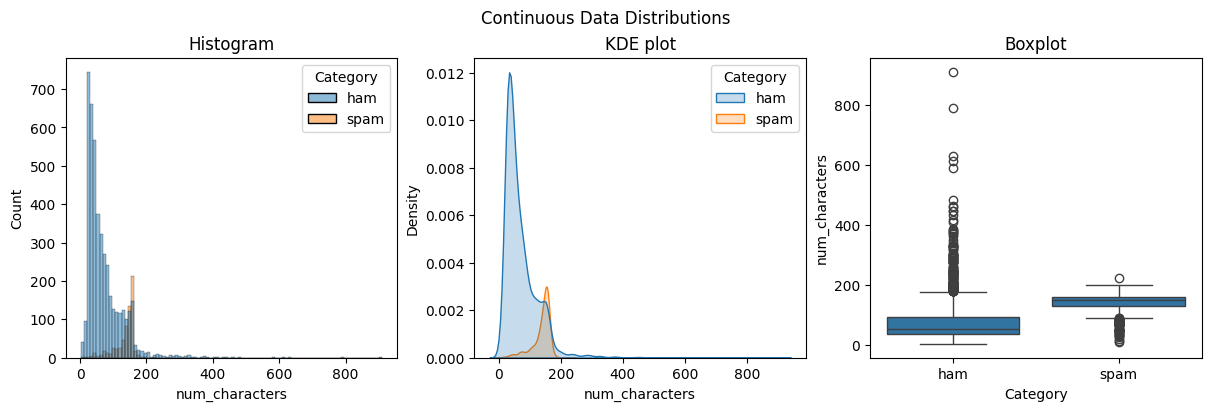

In [28]:
print("Non Visual Analysis")
cont_non_vis_analysis(data,'num_characters')
print("Visual Analysis")
cont_vis_analysis(data,'num_characters')

Non Visual Analysis
count     5157.00
min          1.00
max        220.00
mean        18.56
median      15.00
var        179.72
std         13.41
skew         3.29
kurt        28.28
Name: num_words, dtype: float64

Visual Analysis


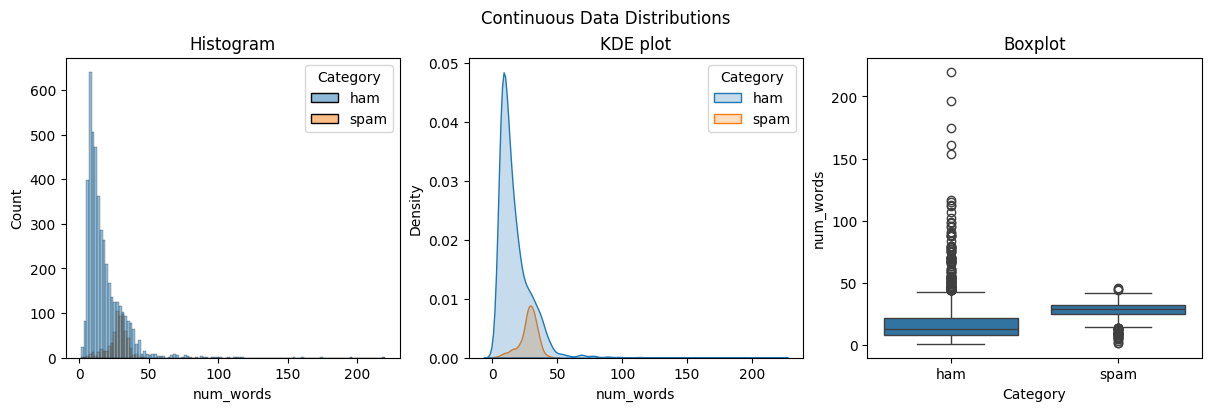

In [29]:
print("Non Visual Analysis")
cont_non_vis_analysis(data,'num_words')
print("Visual Analysis")
cont_vis_analysis(data,'num_words')

In [30]:
## observations
# Spam messages are generally longer (both in characters and words) compared to ham.
# Ham messages are shorter on average but show a wider spread with many extreme outliers.
# Both distributions are right-skewed, meaning most messages are short with a few very long ones.
# Spam messages appear more consistent and concentrated in length, while ham varies more.
# Message length (words/characters) is a strong distinguishing feature between spam and ham.

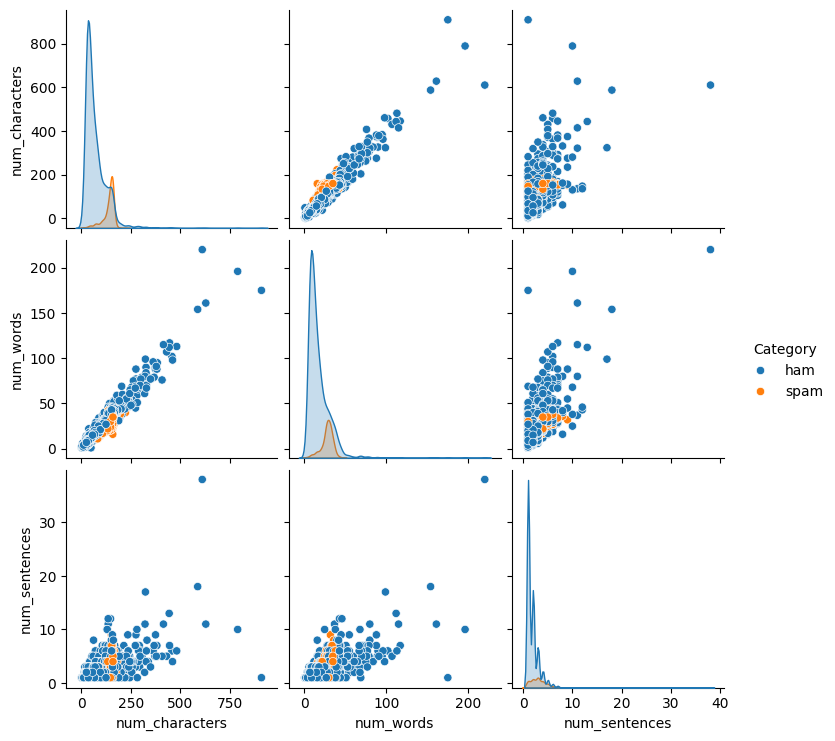

In [31]:
sns.pairplot(data,hue='Category')

In [32]:
# Encode labels: ham=0, spam=1
label_encoder = LabelEncoder()
data['Category'] = label_encoder.fit_transform(data['Category'])

In [33]:
data.head()

,Category,Message,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


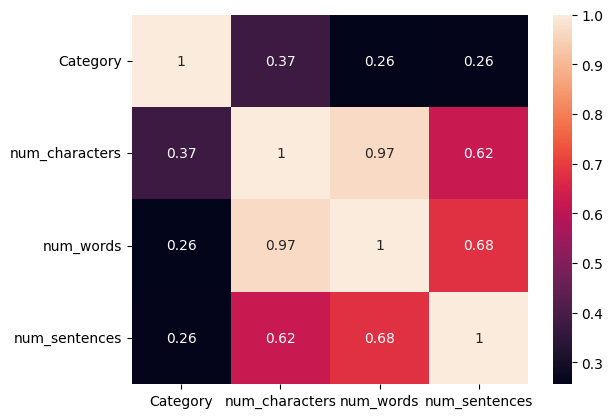

In [34]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Compute correlation
corr = numeric_data.corr()

# Plot heatmap
sns.heatmap(corr, annot=True)
plt.show()

In [35]:
def catg_disc_analysis(data,col):
  print("Value Counts for ",col)
  print(data[col].value_counts())
  print("Null values =",data[col].isna().sum())
  fig,axes=plt.subplots(1,2,figsize=(8,4),layout='constrained')
  fig.suptitle('Categorical / Discrete Num Data Distributions')

  axes[0].set_title('Bar Plot')
  sns.countplot(x=col,data=data,ax=axes[0])

  axes[1].set_title('Pie Chart')
  vc_data=data[col].value_counts()
  axes[1].pie(vc_data,labels=vc_data.index,autopct='%1.1f%%')
  fig.show()

Value Counts for  Category
Category
0    4516
1     641
Name: count, dtype: int64
Null values = 0


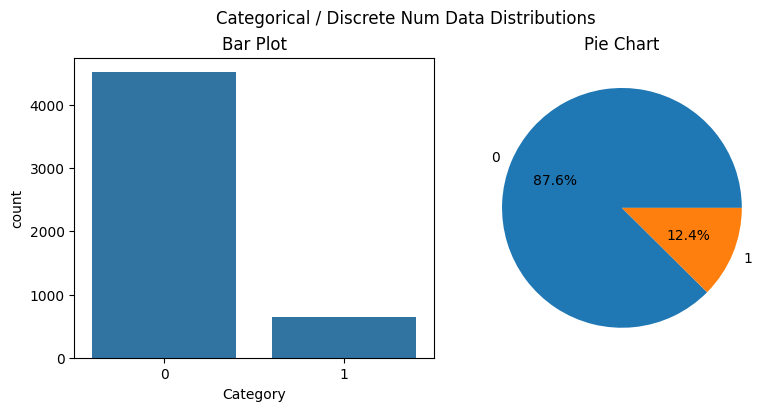

In [36]:
catg_disc_analysis(data,'Category')

In [37]:
## Observations
# As we can see, the classes are imbalanced, so we can consider using some kind of resampling techniques like SMOTE etc.

## Data Pre-processing


In [38]:
data.head()

,Category,Message,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


- Lower case
- Tokenization
- Removing special characters
- Removing stop words and punctuation

In [39]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stopwords
STOPWORDS = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
def tokenizer(text):
    # Lowercase
    text = text.lower()

    # Tokenization: extract words (removes punctuation & special characters automatically)
    tokens = re.findall(r"\b\w+\b", text)

    # Remove stopwords
    tokens = [t for t in tokens if t not in STOPWORDS]

    # Join back into a sentence
    cleaned_text = " ".join(tokens)

    return cleaned_text

In [41]:
tokenizer("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gonna home soon want talk stuff anymore tonight k cried enough today'

In [42]:
# Apply to DataFrame
data["cleaned_message"] = data["Message"].apply(tokenizer)

In [43]:
data.head()

,Category,Message,num_characters,num_words,num_sentences,cleaned_message
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goes usf lives around though


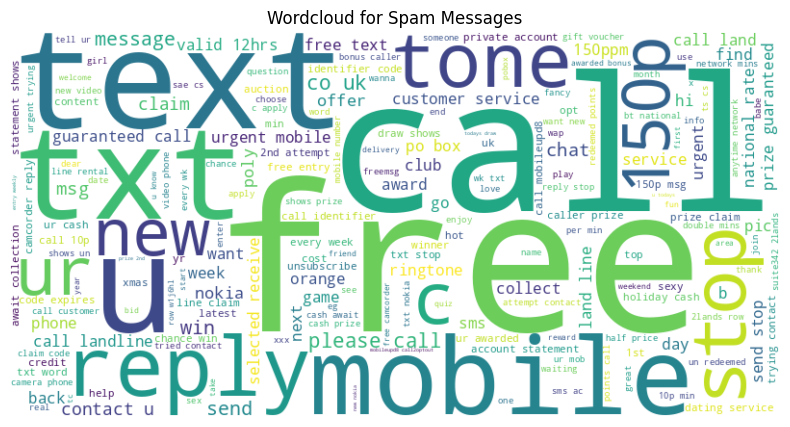

In [44]:
from wordcloud import WordCloud

# Filter for spam messages and join the cleaned messages
spam_text = " ".join(data[data['Category'] == 1]['cleaned_message'])

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

# Plot wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Spam Messages')
plt.show()

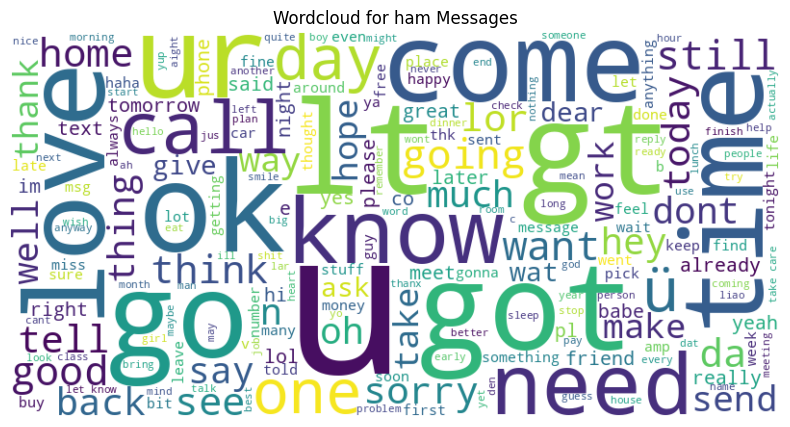

In [45]:
# Filter for ham messages and join the cleaned messages
ham_text = " ".join(data[data['Category'] == 0]['cleaned_message'])

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)

# Plot wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for ham Messages')
plt.show()

In [46]:
data.head()

,Category,Message,num_characters,num_words,num_sentences,cleaned_message
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goes usf lives around though


In [47]:
# Create new DataFrame with only required columns
data_cleaned = data[["Category", "cleaned_message"]].copy()

In [48]:
data_cleaned.head()

,Category,cleaned_message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah think goes usf lives around though


In [49]:
# First split: 80% train, 20% temp (val+test)
df_train, df_temp = train_test_split(data_cleaned, test_size=0.20, shuffle=True, random_state=42)

# Second split: split temp into 10% val and 10% test (equal halves of 20%)
df_val, df_test = train_test_split(df_temp, test_size=0.50, shuffle=True, random_state=42)

df_train.shape, df_val.shape, df_test.shape


((4125, 2), (516, 2), (516, 2))

In [50]:
# create vocabulary
counter=Counter()
# vocab is built only on train data
for text in df_train.cleaned_message:
  tokens = text.split()
  counter.update(tokens)

In [51]:
print(counter)

Counter({'u': 847, '2': 376, 'call': 368, 'get': 293, 'ur': 252, 'go': 230, '4': 229, 'gt': 217, 'lt': 215, 'ok': 201, 'know': 199, 'free': 196, 'got': 195, 'like': 194, 'come': 175, 'good': 175, 'time': 159, 'day': 158, 'love': 155, 'want': 147, 'text': 142, 'going': 140, 'send': 137, 'ü': 136, 'lor': 129, 'one': 129, 'home': 128, 'need': 127, 'today': 126, 'txt': 123, 'still': 122, 'see': 120, 'hi': 119, 'back': 117, 'r': 116, 'da': 110, '1': 110, 'think': 110, 'stop': 109, 'k': 105, 'take': 104, 'dont': 102, 'reply': 102, 'tell': 102, 'n': 99, 'phone': 98, 'c': 97, 'well': 97, 'sorry': 96, 'new': 94, 'mobile': 94, 'hope': 93, 'great': 91, 'oh': 90, 'much': 89, 'please': 87, 'hey': 85, 'night': 85, 'give': 83, 'later': 83, 'pls': 82, 'dear': 80, 'week': 79, 'number': 78, 'wat': 78, 'make': 77, 'msg': 76, 'work': 76, 'way': 75, 'yes': 73, 'already': 73, 'claim': 70, 'yeah': 70, 'really': 69, 'tomorrow': 69, 'ask': 68, 'e': 68, 'www': 67, 'miss': 66, 'im': 66, 'find': 66, 'say': 65, 'b

In [52]:
len(counter)

7505

In [53]:
vocab={'<pad>':0,'<unk>':1}
# unknown token
token_id=2
for word,freq in counter.items():
  if freq>=2:
    vocab[word]=token_id
    token_id+=1
    # only add tokens in vocab who has frequency >=2 in corpus

In [54]:
vocab

{'<pad>': 0,
 '<unk>': 1,
 'got': 2,
 'fujitsu': 3,
 'lot': 4,
 'model': 5,
 'say': 6,
 'really': 7,
 'masters': 8,
 'see': 9,
 'cup': 10,
 'coffee': 11,
 'animation': 12,
 'pain': 13,
 'come': 14,
 'worse': 15,
 'time': 16,
 'also': 17,
 'piece': 18,
 'discuss': 19,
 'u': 20,
 'great': 21,
 'new': 22,
 'offer': 23,
 'double': 24,
 'mins': 25,
 'txt': 26,
 'best': 27,
 'orange': 28,
 'tariffs': 29,
 'get': 30,
 'latest': 31,
 'camera': 32,
 'phones': 33,
 '4': 34,
 'free': 35,
 'call': 36,
 'mobileupd8': 37,
 '08000839402': 38,
 '2stoptxt': 39,
 'cs': 40,
 'noe': 41,
 'ü': 42,
 'da': 43,
 'still': 44,
 'sch': 45,
 'jus': 46,
 'came': 47,
 'back': 48,
 'fr': 49,
 'lunch': 50,
 'wif': 51,
 'sis': 52,
 'leh': 53,
 'going': 54,
 'bath': 55,
 'msg': 56,
 'next': 57,
 'lt': 58,
 'gt': 59,
 'min': 60,
 'congratulations': 61,
 'thanks': 62,
 'good': 63,
 'friend': 64,
 '2': 65,
 '000': 66,
 'xmas': 67,
 'prize': 68,
 'claim': 69,
 'easy': 70,
 '10p': 71,
 'per': 72,
 'minute': 73,
 'bt': 74,
 

In [55]:
len(vocab)

3262

In [56]:
def encode(text, vocab):
    tokens = text.split()   # split string into tokens
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

In [57]:
text=df_train.cleaned_message.iloc[2]
token_ids=encode(text,vocab)
print(text)
print(token_ids)

see cup coffee animation
[9, 10, 11, 12]


In [58]:
class SpamDataset(Dataset):
  def __init__(self,texts,labels,vocab,max_length=150):
    self.texts=texts
    self.labels=labels
    self.vocab=vocab
    self.max_length=max_length
    # max_length will be used for padding and truncation

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    token_ids=encode(text,self.vocab)

    # truncation
    if len(token_ids)>self.max_length:
      token_ids=token_ids[:self.max_length]
    # padding
    if len(token_ids)<self.max_length:
      n_padding=self.max_length-len(token_ids)
      token_ids=token_ids+[self.vocab['<pad>']]*n_padding


    # assert len(token_ids)==self.max_length
    # Convert to tensors
    token_ids = torch.tensor(token_ids, dtype=torch.long)
    label = torch.tensor(label, dtype=torch.float)  # BCEWithLogitsLoss expects float

    return token_ids,label

# in batch tensor we need all vectors to have same size, thats why padding and trncation are needed

In [59]:
train_set = SpamDataset(texts=df_train.cleaned_message.to_list(),labels=df_train.Category.to_list(),vocab=vocab)
val_set = SpamDataset(texts=df_val.cleaned_message.to_list(),labels=df_val.Category.to_list(),vocab=vocab)
test_set = SpamDataset(texts=df_test.cleaned_message.to_list(),labels=df_test.Category.to_list(),vocab=vocab)

In [60]:
train_loader=DataLoader(train_set,batch_size=16,shuffle=True)
val_loader=DataLoader(val_set,batch_size=32,shuffle=False)
test_loader=DataLoader(test_set,batch_size=32,shuffle=False)

In [61]:
# test dataset and dataloader
x=train_set[120]
x[0].shape

torch.Size([150])

In [62]:
batch=next(iter(train_loader))

In [63]:
batch[0].shape

torch.Size([16, 150])

In [64]:
batch[1].shape

torch.Size([16])

In [65]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        self.lstm = nn.LSTM(embed_size,
                            hidden_size,
                            num_layers,
                            batch_first=True,
                            bidirectional=True, # Make LSTM bidirectional
                            dropout=dropout if num_layers > 1 else 0) # Dropout between LSTM layers

        # The input to the linear layer is hidden_size * 2 because of bidirectionality
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embeds)

        # Concatenate the final forward and backward hidden states
        # hidden is of shape [num_layers * num_directions, batch, hidden_size]
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        hidden = self.dropout(hidden)
        out = self.fc(hidden)

        # REMOVE the sigmoid layer. BCEWithLogitsLoss handles it internally.
        return out.squeeze(1)


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:
embed_dim=100
hidden_dim = 128
output_size = 1
num_layers = 2
vocab_size=len(vocab)

In [68]:
model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_size, num_layers).to(device)

In [69]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [70]:
# Train loop
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for texts, labels in train_loader:
        texts = texts.to(device)
        labels = labels.float().to(device)

        outputs = model(texts)  # raw logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)


    train_acc = 100 * correct_train / total_train
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            texts = texts.to(device)
            labels = labels.float().to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)


    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss/len(val_loader):.4f}, '
          f'Val Acc: {val_acc:.2f}%')

Epoch [1/10], Train Loss: 0.1936, Train Acc: 93.53%, Val Loss: 0.1023, Val Acc: 97.09%
Epoch [2/10], Train Loss: 0.0654, Train Acc: 98.23%, Val Loss: 0.1229, Val Acc: 95.93%
Epoch [3/10], Train Loss: 0.0368, Train Acc: 99.03%, Val Loss: 0.1019, Val Acc: 97.09%
Epoch [4/10], Train Loss: 0.0247, Train Acc: 99.39%, Val Loss: 0.1310, Val Acc: 97.09%
Epoch [5/10], Train Loss: 0.0138, Train Acc: 99.61%, Val Loss: 0.1056, Val Acc: 97.29%
Epoch [6/10], Train Loss: 0.0076, Train Acc: 99.81%, Val Loss: 0.1575, Val Acc: 96.51%
Epoch [7/10], Train Loss: 0.0063, Train Acc: 99.88%, Val Loss: 0.1426, Val Acc: 97.29%
Epoch [8/10], Train Loss: 0.0039, Train Acc: 99.93%, Val Loss: 0.1523, Val Acc: 97.09%
Epoch [9/10], Train Loss: 0.0009, Train Acc: 99.98%, Val Loss: 0.1609, Val Acc: 97.29%
Epoch [10/10], Train Loss: 0.0004, Train Acc: 99.98%, Val Loss: 0.1919, Val Acc: 97.09%


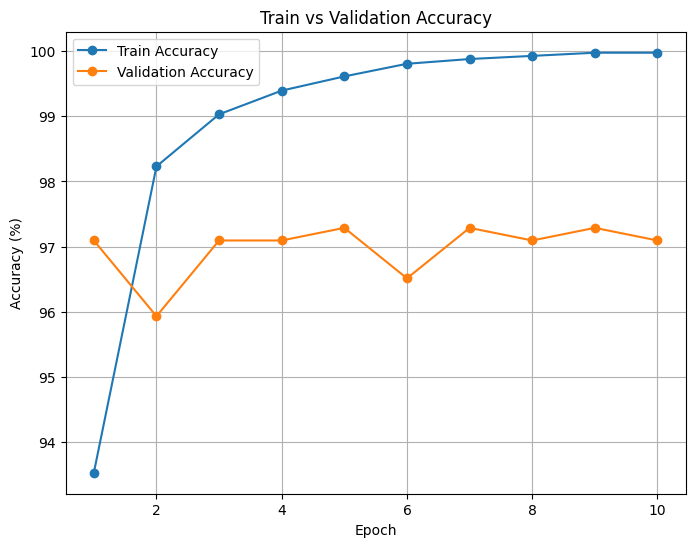

In [71]:
# --- Plot Accuracy ---
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set the model to evaluation mode. This disables layers like Dropout.
model.eval()

# Initialize lists to store all predictions and true labels from the test set.
all_labels = []
all_preds = []

# Disable gradient calculations since we are only performing inference.
with torch.no_grad():
    # Iterate over each batch in the test data loader.
    for texts, labels in test_loader:
        # Move the batch of texts and labels to the configured device (GPU or CPU).
        texts = texts.to(device)
        labels = labels.to(device)

        # Get raw logit outputs from the model.
        outputs = model(texts)

        # Apply the sigmoid function to the raw logits to get probabilities.
        # Then, classify as 1 (spam) if probability > 0.5, otherwise 0 (ham).
        # Use .long() to convert the resulting boolean tensor to integers (0 or 1).
        predicted = (torch.sigmoid(outputs) > 0.5).long()

        # Move labels and predictions to the CPU and convert to NumPy arrays to store them.
        all_labels.extend(labels.cpu().long().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Convert the lists of all labels and predictions to NumPy arrays for metric calculations.
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)


# Calculate and Print Overall Test Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Test Accuracy: {accuracy * 100:.2f}%\n')


Overall Test Accuracy: 98.26%



In [73]:
# Print the Classification Report
# This report provides key metrics like precision, recall, and F1-score for each class.
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['ham', 'spam']))

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       448
        spam       0.95      0.91      0.93        68

    accuracy                           0.98       516
   macro avg       0.97      0.95      0.96       516
weighted avg       0.98      0.98      0.98       516



Confusion Matrix:


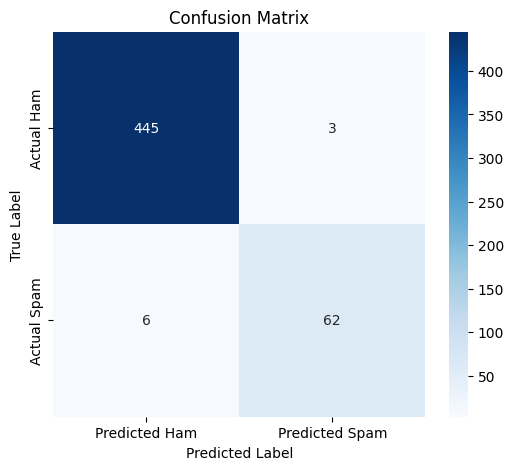

In [74]:
# Display the Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix for a better visual representation.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Save the model

In [75]:
# Save model weights
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Deep Learning/RNN_LSTM_Project/spam_classifier.pth")


In [76]:
# Save vocab (Python dictionary) using pickle
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Deep Learning/RNN_LSTM_Project/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)